In [242]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from simulator import Simulator
from observability import SlidingEmpiricalObservabilityMatrix, FisherObservability, ObservabilityMatrixImage
from util import colorline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up simulator

In [243]:
# Set time-step
dt = 0.01  # [s]

In [244]:
# Define dynamics function
state_names = ['g', 'd']
input_names = ['u']
def f(X, U, t):
    # States
    g, d = X
    
    # Inputs
    u = U[0]
    
    # Dynamics
    g_dot = u
    d_dot = 0*u
    
    # Package and return xdot
    x_dot = [g_dot, d_dot]
    
    return x_dot

In [245]:
# Define measurement function
measurement_names = ['r']
def h(X, U, t):
    # States
    g, d = X
    
    # Inputs
    u = U
    
    # Measurements
    Y = [g/d]
    
    # Return measurement
    return Y


In [246]:
# Define initial state and controls (must be same size as X & U)
X0 = [2, 3]
U0 = [0]

In [247]:
# Create simulator object
simulator = Simulator(f, h, X0, U0, dt=dt,
                      state_names=state_names, measurement_names=measurement_names, input_names=input_names)

In [248]:
# Set the initial state
x0 = simulator.x0.copy()
x0['g'] = 2.0
x0['d'] = 3.0
x0

{'g': 2.0, 'd': 3.0}

In [249]:
# Set the inputs
tsim1 = np.arange(0, 3, step=dt)
tsim2 = np.arange(3, 6, step=dt)
tsim3 = np.arange(6, 9, step=dt)
tsim = np.hstack((tsim1, tsim2, tsim3))

u1 = np.sin(3*tsim1)
u2 = 1e-5*np.sin(3*tsim2)
u3 = np.sin(3*tsim3)
u_total = np.hstack((u1, u2, u3))

u = simulator.u.copy()
u['u']= u_total
# u

In [250]:
# Run simulator with set initial state & inputs
y_sim = simulator.simulate(x0=x0, u=u)

In [251]:
# Save simulation data
x_sim = simulator.x.copy()
u_sim = simulator.u.copy()
t_sim = simulator.time.copy()
# sim_data = pd.DataFrame(simulator.sim_data)

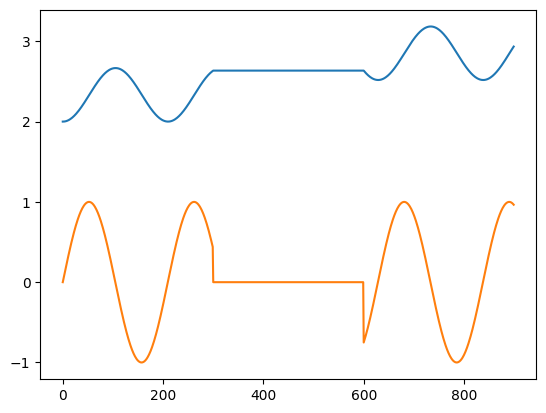

In [252]:
plt.plot(x_sim['g'])
plt.plot(u_sim['u'])

# Observability

In [253]:
# Construct observability matrix in sliding windows
w = 6  # window size
SEOM = SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4, parallel=False)

In [254]:
n_window = len(SEOM.O_df_sliding)
print(n_window, 'windows')

895 windows


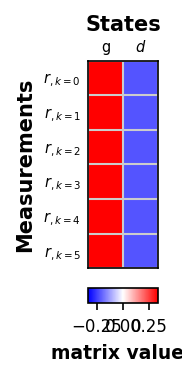

In [255]:
# Visualize observability matrix
OI = ObservabilityMatrixImage(SEOM.O_df_sliding[0], vmax_percentile=100, vmin_ratio=1.0, cmap='bwr')
OI.plot()

# Compute Fisher information matrix & inverse for each sliding window

In [256]:
# Choose sensors to use from O
o_sensors = ['r']

# Chose states to use from O
o_states = ['g', 'd']

# Choose time-steps to use from O
window_size = 6
o_time_steps = np.arange(0, window_size, step=1)

In [257]:
# Set each sensor noise level separately
sensor_noise = {'x': 0.1, 'v': 0.1, 'm': 0.1, 'k': 0.1, 'b': 0.1, 'r':0.1}

In [258]:
# Compute Fisher information matrix & inverse for each sliding window
EV = []  # collect error variance data for each state over time
shift_index = int(np.round((1/2) * window_size))
shift_time = shift_index * dt  # shift the time forward by half the window size
for k in range(n_window):  # each window
    # Get full O
    O = SEOM.O_df_sliding[k]
    
    # Get subset of O
    O_subset = O.loc[(o_sensors, o_time_steps), o_states].sort_values(['time_step', 'sensor'])
    
    # Compute Fisher information & inverse
    FO = FisherObservability(O_subset, sensor_noise_dict=sensor_noise, sigma=1e-6)
    
    # Collect error variance data
    ev = FO.error_variance.copy()
    ev.insert(0, 'time_initial', SEOM.t_sim[k] + 0.0*shift_time)
    EV.append(ev)

# Concatenate error variance & make same size as simulation data
EV = pd.concat(EV, axis=0, ignore_index=True)
EV.index = np.arange(shift_index, EV.shape[0] + shift_index, step=1, dtype=int)
time_df = pd.DataFrame(np.atleast_2d(tsim).T, columns=['time'])
EV_aligned = pd.concat((time_df, EV), axis=1)

In [259]:
EV_aligned

,time,time_initial,g,d
0,0.00,NaN,NaN,NaN
1,0.01,NaN,NaN,NaN
2,0.02,NaN,NaN,NaN
3,0.03,0.00,191444.779549,430320.587788
4,0.04,0.01,135294.535889,303881.279670
...,...,...,...,...
895,8.95,8.92,4321.249656,4656.471416
896,8.96,8.93,4385.102956,4693.069372
897,8.97,8.94,4457.770644,4738.574303
898,8.98,NaN,NaN,NaN


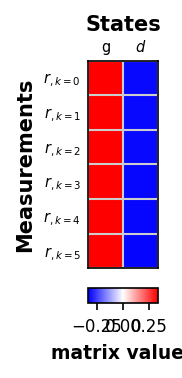

In [260]:
# Visualize observability matrix subset
OI = ObservabilityMatrixImage(O_subset, vmax_percentile=100, vmin_ratio=1.0, cmap='bwr')
OI.plot()

# Plot states & error variance

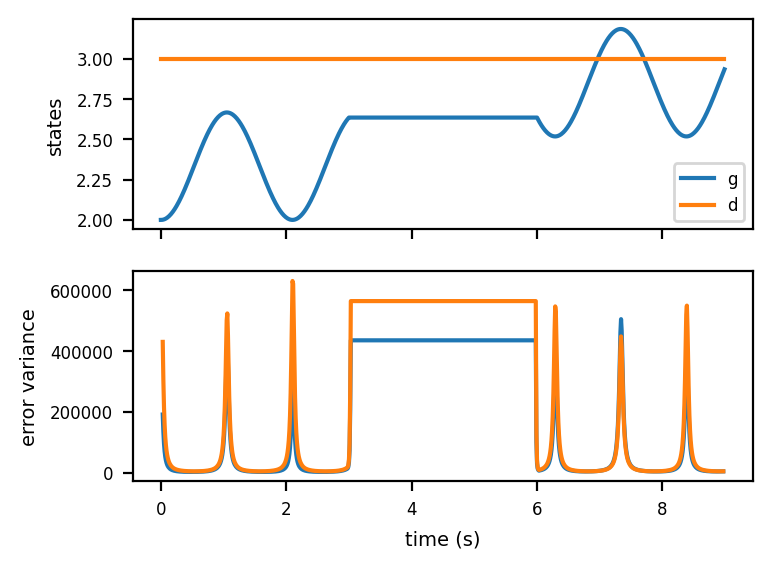

In [261]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3), dpi=200, sharex=True)

ax[0].plot(t_sim, x_sim['g'], label='g')
ax[0].plot(t_sim, x_sim['d'], label='d')
ax[0].set_ylabel('states', fontsize=7)
ax[0].legend(fontsize=6)

ax[1].plot(EV_aligned['time'], EV_aligned['g'])
ax[1].plot(EV_aligned['time'], EV_aligned['d'])
# ax[1].set_ylim(-1e5, 1e6)
ax[1].set_ylabel('error variance', fontsize=7)
ax[1].set_xlabel('time (s)', fontsize=7)
# ax[1].set_yscale('log')

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    

# Plot error variance as color on state time-series

In [262]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

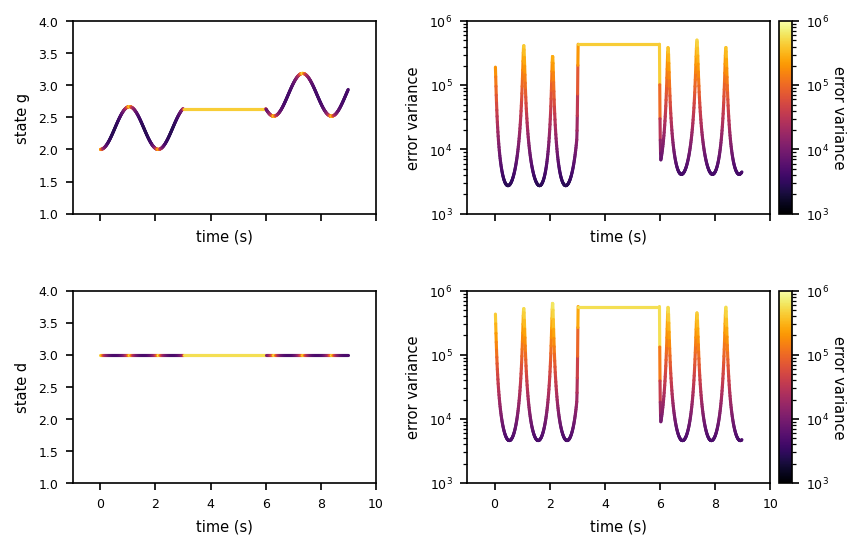

In [263]:
n_state = len(o_states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno'

log_tick_low = 3
log_tick_high = 6
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(o_states):
    colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('error variance', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(1, 4)
    ax[n, 0].set_ylabel('state ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('error variance', fontsize=7)


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-1, 10)
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)